# This script will pair the Udacity driving data between steering angle and center camera image file name based on closest timestamp in Epoch time
Created by: Zhongtao Yang
Date: 11/4/2016

It uses pandas to read two csv files and find the best pairing based on timestamp for both steering angle and images, one has steering angles and corresponding timestamp, and the other one has images' file names with corrsponding timestamp. Since the timestamp and image timestamp are not exactly the same for each pair, here I use pandas to pair them based on closest timestamp in a short time window.

## Part 1. prepare the data pair table in pandas dataframe format

In [3]:
import pandas as pd
import numpy as np

#read dataframe of steering wheel angle
df_steering = pd.read_csv('steering.csv')
df_steering = df_steering[['timestamp','angle']] # keep only timestamp and angle

#read dataframe of camera information
df_camera = pd.read_csv('camera.csv')

# obtain only the center_camera
df_center_camera = df_camera[df_camera['frame_id'] == 'center_camera']

#reorder the index of the df_center_camera
df_center_camera = df_camera[df_camera['frame_id'] == 'center_camera']
df_center_camera.index = range(df_center_camera.shape[0])
df_center_camera = df_center_camera[['timestamp','filename']] # keep only timestamp and image filename

#build a new dataframe which will be the best matching between steering angle and camera filename based on closest epoch timestamp
# merge two dataframe based on sorted timestamp
df_paired = pd.merge(df_center_camera, df_steering, on='timestamp', how='outer',sort='timestamp')

#use the immediate next row's angle to join the current row's angle, where the current row is the row that has camera filename at current timestamp
df_paired['angle'][np.where(df_paired['filename'].notnull())[0]] = df_paired['angle'][np.where(df_paired['filename'].notnull())[0] + 1]  
input_df = df_paired.dropna()
input_df.index = range(input_df.shape[0])
input_df


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,timestamp,filename,angle
0,1475520790430827155,center/1475520790430827155.jpg,-0.368264
1,1475520790481041481,center/1475520790481041481.jpg,-0.368264
2,1475520790530880584,center/1475520790530880584.jpg,-0.368264
3,1475520790580930648,center/1475520790580930648.jpg,-0.368264
4,1475520790630894119,center/1475520790630894119.jpg,-0.368264
5,1475520790680914581,center/1475520790680914581.jpg,-0.368264
6,1475520790730852457,center/1475520790730852457.jpg,-0.368264
7,1475520790780899706,center/1475520790780899706.jpg,-0.368264
8,1475520790831056920,center/1475520790831056920.jpg,-0.368264
9,1475520790880775710,center/1475520790880775710.jpg,-0.368264


## part 2. set up the tensorflow data input with filename_queue and tf.WhileFileReader to read images

### load all images from disk by giving filenames queue in multitheads

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
global downsample_ratio
downsample_ratio = 4
def loadImageBatch(filenames):
    # Make a queue of file names
    filename_queue = tf.train.string_input_producer(filenames, shuffle=False)
    #     tf.train.match_filenames_once("center/*.jpg")) this will load all the images

    # Read an entire image file which is required since they're JPEGs,
    image_reader = tf.WholeFileReader()

    # Read a whole file from the queue
    _, image_file = image_reader.read(filename_queue)

    # Decode the image as a JPEG file and save into Tensor for later
    image = tf.image.decode_jpeg(image_file,ratio=downsample_ratio)

    # Start a new session to show example output.
    # Coordinate the loading of image files.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    # because the size of image is too large, downsample it here
    image_tensor = np.zeros([len(filenames),480/downsample_ratio,640/downsample_ratio,3], dtype=np.float32)
    # Get an image tensor and print its value.
    for i in range(len(filenames)):
        image_tensor[i,:,:,:] = np.asarray(sess.run([image]), dtype=np.float32)
    # Finish off the filename queue coordinator.
#     coord.request_stop()
#     coord.join(threads)
    return image_tensor

### Randomly obtain a batch
This function will randomly generate a batch from the whole dataset, by randomly choosing indexes from the pandas dataframe. Then slicing out the image file name paird with current steering angle and send to tensorflow file reader

In [5]:
def get_random_batch(batch_size):
    global image
    image = np.empty([batch_size,480/downsample_ratio,640/downsample_ratio,3])
    # Number of images in the training-set.
    num_images = len(input_df)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)
    
    fileNameList = input_df['filename'][idx].tolist()
#     x_batch = input_df.loc[idx]
    image = loadImageBatch(fileNameList)
        
    y_batch = input_df['angle'][idx].tolist()

    return image,y_batch,idx

### Validate the batch image and its corresponding label are correct pairs
Take a batch of 100 random pairs to test the data file reading and validate the pair is correct by looking into the raw files

shape of x_batch (100, 120, 160, 3)
shape of y_batch (100,) 

the first pair in the batch has steering angle : 0.368264466524
the angle in the original table at current index is also: 0.368264466524
the first pair in the batch has photo:

 the corresponding photo is:
center/1475523684339469128.jpg


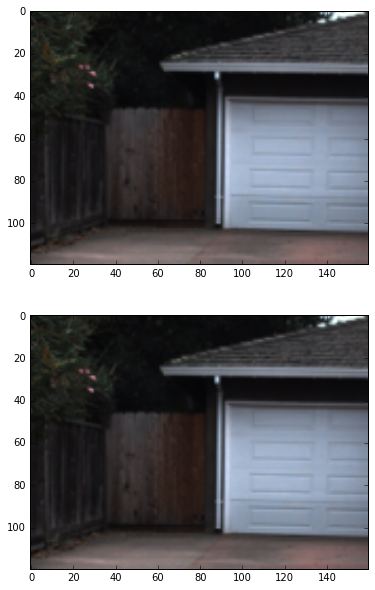

In [51]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
batch_size = 100
x_batch,y_batch,idx = get_random_batch(batch_size)
# validate the shape of batch images and labels are correct
print 'shape of x_batch',np.shape(x_batch)
print 'shape of y_batch',np.shape(y_batch),'\n'
print 'the first pair in the batch has steering angle :',(y_batch[0])
print 'the angle in the original table at current index is also:',input_df['angle'][idx[0]]

print 'the first pair in the batch has photo:'
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True) 
plt.figure(figsize=(20, 10))
plt.subplot(2,1,1)
plt.imshow(np.asarray(x_batch[0,:,:,:],dtype=np.uint8))
print '\n the corresponding photo is:'
print input_df['filename'][idx[0]]
currentfileName = [input_df['filename'][idx[0]]]
ret = loadImageBatch(currentfileName)
plt.subplot(2,1,2)
plt.imshow(np.asarray(ret[0,:,:,:],dtype=np.uint8))


## Build the Neural Network based on NVIDIA paper
Now start to construct the convolutional neural network based on Nidia's paper

In [52]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

# define some global variables
global batchSize
batchSize = 20
global testSize
testSize = 50
global num_iteration
# ImageSize = [480/downsample_ratio, 640/downsample_ratio, 3]
num_iteration = 1000;


def compute_accuracy(v_xs, v_ys):
    global prediction
    y_pre = sess.run(prediction, feed_dict={xs: v_xs, keep_prob: 1})

#     Y = tf.expand_dims(tf.cast(tf.argmax(v_ys,1), tf.float32),1)

    result1 = sess.run(error, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 1})
#     result2 = sess.run(Y, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 1})
    return result1

def evaluate(v_xs):
    predictedVal = sess.run(prediction, feed_dict={xs: v_xs, keep_prob: 1})
    return predictedVal

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d2(x, W): # stride 2x2
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='VALID')

def conv2d0(x, W): # no stride
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def max_pool_2x2(x): # Not needed
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

# define placeholder for inputs to network
xs = tf.placeholder(tf.float32, [None, 120, 160, 3]) # 120 x 160 x 3
ys = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)

# udacity image size : 120 x 160 x 3

## need to add normalization here

## conv1 layer ##
W_conv1 = weight_variable([5,5,3,24]) # patch 5x5, stride 2, in size 1, out size 32
b_conv1 = bias_variable([24])
h_conv1 = tf.nn.relu(conv2d2(xs, W_conv1) + b_conv1) # feature map @ layer 1 size 31x98 -> 58x78 (even/2-2)

## conv2 layer ##
W_conv2 = weight_variable([5,5, 24, 36]) # patch 5x5, stride 2, in size 24, out size 36
b_conv2 = bias_variable([36])
h_conv2 = tf.nn.relu(conv2d2(h_conv1, W_conv2) + b_conv2) # feature map @ layer 2 size 14x47 -> 27x37 (odd + 1)/2-2

## conv3 layer 
W_conv3 = weight_variable([5,5, 36, 48]) # patch 5x5, stride 2, in size 36, out size 48
b_conv3 = bias_variable([48])
h_conv3 = tf.nn.relu(conv2d2(h_conv2, W_conv3) + b_conv3) # feature map @ layer 3 size 5x22 -> 12x17

## conv4 layer 
W_conv4 = weight_variable([3,3, 48, 64]) # patch 3x3, stdie 1, in size 48, out size 64
b_conv4 = bias_variable([64])
h_conv4 = tf.nn.relu(conv2d0(h_conv3, W_conv4) + b_conv4) # feature map @ layer 4 size 3x20 -> 10x15

## conv5 layer 
W_conv5 = weight_variable([3,3, 64, 64]) # patch 3x3, stride 1, in size 32, out size 64
b_conv5 = bias_variable([64])
h_conv5 = tf.nn.relu(conv2d0(h_conv4, W_conv5) + b_conv5) # feature map @ layer 5 size 1x18 -> 8x13

## flatten ##
# [n_samples, 1, 18, 64] ->> [n_samples, 1*18*64]
h_conv5_flat = tf.reshape(h_conv5, [-1, 8*13*64])

## fully_connected_layer 1 ##
W_fc1 = weight_variable([8*13*64, 100])
b_fc1 = bias_variable([100])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)
# h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## fully_connected_layer 2  ##
W_fc2 = weight_variable([100, 50])
b_fc2 = bias_variable([50])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)

## fully_connected_layer 3  ##
W_fc3 = weight_variable([50, 10])
b_fc3 = bias_variable([10])
h_fc3 = tf.matmul(h_fc2, W_fc3) + b_fc3

## fully_connected_layer 4  ##
W_fc4 = weight_variable([10, 1])
b_fc4 = bias_variable([1])
prediction = tf.nn.relu(tf.matmul(h_fc3, W_fc4) + b_fc4)


# define the cost and optimizer for optimization, and error is used for evaluation
#===========
# cost = tf.reduce_mean(tf.pow(prediction - ys, 2))
cost = tf.reduce_mean(tf.pow(prediction - ys,2))
# error = tf.reduce_mean(tf.pow(prediction - ys, 2))
error = tf.reduce_mean(tf.pow(prediction - ys,2))
# Gradient descent
train_step = tf.train.AdamOptimizer(1e-3).minimize(cost)
#======


### Start the session and initalize all variables
Start training process here

In [53]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [55]:


def train():
    for i in range(num_iteration):
        batch_xs, batch_ys,_ = get_random_batch(batchSize)
        batch_ys = np.expand_dims(batch_ys, axis=1)
        
        sess.run(train_step, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: 0.8})
    #     print 'finished training current batch'
        if i % 10 == 0:
    #         testImg = mnist.test.images[:testSize,:]
    #         testLabels = mnist.test.labels[:testSize,:]
            testImg,testLabels,_ = get_random_batch(testSize)
            testLabels = np.expand_dims(testLabels, axis=1)
            res1 = compute_accuracy(testImg, testLabels)
            print 'accuracy at step',i,':',res1
            dataInput = testImg[0:1,:,:,:];
            dataOutput = testLabels[0,:];
            currResult = evaluate(dataInput)
            print 'True angle is',dataOutput,'predict angle is',currResult
            
if __name__ == '__main__':
    train()

accuracy at step 0 : 1.29701
True angle is [-0.38571778] predict angle is [[ 0.]]
